<a href="https://colab.research.google.com/github/masibay/cust-personal-loan/blob/main/custBankLoan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DE Project : Customer Personal Loan

1. **Input** :
   - Dataset based on kaggle https://www.kaggle.com/datasets/mahnazarjmand/bank-personal-loan/data
2. **Goal** : Analyzing Bank Customer Profiles to Assess Their Loan Application Eligibility Primary.

Requirements:
- Residency in one of the following counties: Los Angeles, Orange, San Francisco, Santa Clara, San Diego, Alameda, Sacramento, San Mateo, Contra Costa, Marin, Riverside.
- Age range: Minimum of 23 years and a maximum of 65 years.
- Minimum of 2 years of professional experience.
- Minimum income requirements:
  - 3000 USD/month in Los Angeles County.
  - 2500 USD/month in counties outside Los Angeles County.

3. **Output** :
   - Data pipeline (Extract, Transform).
   - Visualize Data.
   - Classification Model (Random Forest).

##Config Pyspark

In [ ]:
!pip install -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pyspark
from pyspark.sql import SparkSession
import findspark
findspark.init()

In [ ]:
spark = SparkSession.builder.appName("custLoan")\
        .master("local[*]")\
        .config("spark.driver.memory","12g")\
        .config("spark.driver.maxResultSize", "0")\
        .config("spark.python.worker.memory", "12g")\
        .config("spark.memory.fraction","0.6")\
        .config("spark.shuffle.io.preferDirectBufs", True)\
        .config("spark.sql.repl.eagerEval.enabled", True)\
        .getOrCreate()

##Download Dataset Bank Personal Loan From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [ ]:
!kaggle datasets download "mahnazarjmand/bank-personal-loan"

Dataset URL: https://www.kaggle.com/datasets/mahnazarjmand/bank-personal-loan
License(s): unknown
  0% 0.00/60.6k [00:00<?, ?B/s]
100% 60.6k/60.6k [00:00<00:00, 5.10MB/s]


In [ ]:
!unzip bank-personal-loan.zip

Archive:  bank-personal-loan.zip
  inflating: Bank_Personal_Loan_Modelling(1).csv  


## Load Dataset CSV

In [ ]:
from pyspark.sql import functions as F

In [ ]:
link = "/content/Bank_Personal_Loan_Modelling(1).csv"

In [ ]:
df = spark.read\
      .option("header", True)\
      .option("delimiter", ",")\
      .csv(link)

In [ ]:
print(f"{df.dtypes}\n\nTotal rows: {df.count()} \nTotal columns: {len(df.columns)}")

[('ID', 'string'), ('Age', 'string'), ('Experience', 'string'), ('Income', 'string'), ('ZIP Code', 'string'), ('Family', 'string'), ('CCAvg', 'string'), ('Education', 'string'), ('Mortgage', 'string'), ('Personal Loan', 'string'), ('Securities Account', 'string'), ('CD Account', 'string'), ('Online', 'string'), ('CreditCard', 'string')]

Total rows: 5000 
Total columns: 14


About Column Dataset :
 - ID : Customer ID
 - Age : Customer's age in completed years
 - Experience : years of professional experience
 - Income : Annual income of the customer
 - ZIP Code : Home Address ZIP code.
 - Family : Family size of the customer
 - CCAvg : Avg. spending on credit cards per month
 - Education : Education Level.
    - Undergrad
    - Graduate
    - Advanced/Professional
 - Mortgage : Value of house mortgage if any.
 - Personal Loan : Did this customer accept the personal loan offered in the last campaign?
 - Securities Account : Does the customer have a securities account with the bank?
 - CD Account : Does the customer have a certificate of deposit (CD) account with the bank?
 - Online : Does the customer use internet banking facilities?
 - CreditCard: Does the customer use credit card ?



## Transform Data 01 : Rename Column & Change Data Types

Rename Column :

- Personal Loan to PersonalLoan.
- Securities Account to SecuritiesAccount.
- CD Account to CDAccount.
- ZIP Code to ZIPCode

In [ ]:
df = df.withColumnRenamed("Personal Loan","PersonalLoan") \
      .withColumnRenamed("Securities Account", "SecuritiesAccount") \
      .withColumnRenamed("CD Account", "CDAccount") \
      .withColumnRenamed("ZIP Code","ZIPCode")

Change Data Types :
  - ID to int
  - Age to int
  - Experience to int
  - Income to float
  - ZIP Code to int
  - Family to int
  - CCAvg to float
  - Education to int
  - Mortgage to int
  - Personal Loan to int
  - Securities Account to int
  - CD Account to int
  - Online to int
  - CreditCard to int

In [ ]:
dataTypes = {
    'int' : ['ID','Age','Experience','ZIPCode', 'Family', 'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard'],
    'float' : ['Income', 'CCAvg']
}

def changeData(data):
  for (k, v) in dataTypes.items():
    for c in v:
      if c in data.columns:
        data = data.withColumn(c, data[c].cast(k))
  return data

df = changeData(df)

In [ ]:
df.dtypes

[('ID', 'int'),
 ('Age', 'int'),
 ('Experience', 'int'),
 ('Income', 'float'),
 ('ZIPCode', 'int'),
 ('Family', 'int'),
 ('CCAvg', 'float'),
 ('Education', 'int'),
 ('Mortgage', 'int'),
 ('PersonalLoan', 'int'),
 ('SecuritiesAccount', 'int'),
 ('CDAccount', 'int'),
 ('Online', 'int'),
 ('CreditCard', 'int')]

## Transform Data 02 : Add Column County based on ZIP Code

In [ ]:
!pip install -q pgeocode

In [ ]:
import pgeocode

nomi = pgeocode.Nominatim('us')

def getCountyInfo(zipcode):
    location = nomi.query_postal_code(zipcode)
    if location is not None:
        return location.county_name
    else:
        return None

get_county_info_udf = F.udf(getCountyInfo, F.StringType())
df = df.withColumn("County", get_county_info_udf(df["ZIPCode"]))

In [ ]:
df.show(3)

+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
| ID|Age|Experience|Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|     County|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
|  1| 25|         1|  49.0|  91107|     4|  1.6|        1|       0|           0|                1|        0|     0|         0|Los Angeles|
|  2| 45|        19|  34.0|  90089|     3|  1.5|        1|       0|           0|                1|        0|     0|         0|Los Angeles|
|  3| 39|        15|  11.0|  94720|     1|  1.0|        1|       0|           0|                0|        0|     0|         0|    Alameda|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
only showing top 3 rows



## Transform Data 03 : Fix Data if There is a **Nulls**, **Duplicates** and **Minus Values**

In [ ]:
#Check values if there is nulls
null_counts = [
    F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]
#Check values if there is duplicate
duplicate_rows = df.groupBy(df.columns) \
                   .count() \
                   .filter(F.col("count") > 1)

In [ ]:
duplicate_rows.show()

+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+-----+
| ID|Age|Experience|Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|County|count|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+-----+
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+-----+



Checking Nulls

In [ ]:
df.select(null_counts).show()

+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+
| ID|Age|Experience|Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|County|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+
|  0|  0|         0|     0|      0|     0|    0|        0|       0|           0|                0|        0|     0|         0|    41|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+



In [ ]:
#Create Temporary SQL
nullValues = df.createOrReplaceTempView("nullValues")

In [ ]:
query = """
SELECT ZIPCODE, COUNT (COUNTY) AS TotalNull
FROM nullValues
WHERE COUNTY IS NULL OR County = 'NaN'
GROUP BY ZIPCode
ORDER BY ZIPCODE ASC
"""
spark.sql(query)

ZIPCODE,TotalNull
9307,1
92634,5
92709,7
92717,22
96651,6


Fix Nulls

In [ ]:
CountyDict = {'9307' : 'Armed Forces',
              '92634': 'Orange',
              '92709': 'Orange',
              '92717': 'Orange',
              '96651': 'Armed Forces'}

In [ ]:
from functools import reduce

# Replace the County Nulls based on ZIPCode
conditions = reduce(
    lambda acc, key: acc.when(F.col("ZIPCode") == key, F.lit(CountyDict[key])),
    CountyDict,
    F.when(F.col("ZIPCode") == list(CountyDict.keys())[0], F.lit(CountyDict[list(CountyDict.keys())[0]]))
)

df = df.withColumn("County", conditions.otherwise(df["County"]))

In [ ]:
df.select(null_counts).show()

+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+
| ID|Age|Experience|Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|County|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+
|  0|  0|         0|     0|      0|     0|    0|        0|       0|           0|                0|        0|     0|         0|     0|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+------+



Fix Data Minus Values

In [ ]:
minusValues = df.createOrReplaceTempView("minusValues")

In [ ]:
from pyspark.sql import functions as F

#Check Values in Column if there is a minus Values
def getNegativeValues(df):
    queries = []
    for column in df:
        query = f"""
        SELECT '{column}' AS ColumnName, COUNT(*) AS NegativeCount
        FROM minusValues
        WHERE {column} < 0
        """
        queries.append(query)
    return "\nUNION ALL\n".join(queries)

columns = ["Age", "Experience", "Income", "ZIPCode","Family","CCAvg","Education","PersonalLoan","SecuritiesAccount","CDAccount","Online","CreditCard","Mortgage"]

sql_query = getNegativeValues(columns)

In [ ]:
df_minusValues = spark.sql(sql_query)
df_minusValues.show()

+-----------------+-------------+
|       ColumnName|NegativeCount|
+-----------------+-------------+
|              Age|            0|
|       Experience|           52|
|           Income|            0|
|          ZIPCode|            0|
|           Family|            0|
|            CCAvg|            0|
|        Education|            0|
|     PersonalLoan|            0|
|SecuritiesAccount|            0|
|        CDAccount|            0|
|           Online|            0|
|       CreditCard|            0|
|         Mortgage|            0|
+-----------------+-------------+



In [ ]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType

def replace_negative_values(df):
    for column in df.columns:
        if df.schema[column].dataType in [IntegerType(), FloatType(), DoubleType()]:
            df = df.withColumn(column, F.when(F.col(column) < 0, 0).otherwise(F.col(column)))
    return df

df_fixed = replace_negative_values(df)

In [ ]:
df_fixed.show(3)

+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
| ID|Age|Experience|Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|     County|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
|  1| 25|         1|  49.0|  91107|     4|  1.6|        1|       0|           0|                1|        0|     0|         0|Los Angeles|
|  2| 45|        19|  34.0|  90089|     3|  1.5|        1|       0|           0|                1|        0|     0|         0|Los Angeles|
|  3| 39|        15|  11.0|  94720|     1|  1.0|        1|       0|           0|                0|        0|     0|         0|    Alameda|
+---+---+----------+------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+
only showing top 3 rows



## Transform Data 04 : Add Column Age_Gap & Experience_Gap

In [ ]:
#Create New Column Age_Gap
df_fixed = df_fixed.withColumn('Age_Gap',
    F.when((df_fixed.Age >= 23) & (df_fixed.Age <= 30), '23-30')
    .when((df_fixed.Age >= 31) & (df_fixed.Age <= 40), '31-40')
    .when((df_fixed.Age >= 41) & (df_fixed.Age <= 50), '41-50')
    .when((df_fixed.Age >= 51) & (df_fixed.Age <= 60), '51-60')
    .when((df_fixed.Age >= 61) & (df_fixed.Age <= 65), '61-65')
    .when((df_fixed.Age >= 61), '66+')
)

#Create New Column Experience_Gap
df_fixed = df_fixed.withColumn('Experience_Gap',
    F.when((df_fixed.Experience >= 0) & (df_fixed.Experience <= 1), '0-1')
    .when((df_fixed.Experience >= 2) & (df_fixed.Experience <= 5), '2-5')
    .when((df_fixed.Experience > 5) & (df_fixed.Experience <= 10), '6-10')
    .when((df_fixed.Experience > 10) & (df_fixed.Experience <= 15), '11-15')
    .when((df_fixed.Experience > 15) & (df_fixed.Experience <= 20), '16-20')
    .when(df_fixed.Experience > 20, '21+')
)

## Transform Data 05 : Change Annual Income to Monthly Income

In [ ]:
#Check The Average, min and max of the income
df_fixed.agg(
    F.avg(F.col('income')).alias('avg_income'),
    F.min(F.col('income')).alias('min_income'),
    F.max(F.col('income')).alias('max_income')
).show()

+----------+----------+----------+
|avg_income|min_income|max_income|
+----------+----------+----------+
|   73.7742|       8.0|     224.0|
+----------+----------+----------+



In [ ]:
#Since The Dataset Description its Annual, change the income to Monthly and the income x1000
df_fixed = df_fixed.withColumn('Income', F.expr("(Income * 1000) / 12"))

df_fixed = df_fixed.withColumn('Income',F.round(df_fixed['Income'],3))

In [ ]:
df_fixed.show(3)

+---+---+----------+--------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+-------+--------------+
| ID|Age|Experience|  Income|ZIPCode|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|     County|Age_Gap|Experience_Gap|
+---+---+----------+--------+-------+------+-----+---------+--------+------------+-----------------+---------+------+----------+-----------+-------+--------------+
|  1| 25|         1|4083.333|  91107|     4|  1.6|        1|       0|           0|                1|        0|     0|         0|Los Angeles|  23-30|           0-1|
|  2| 45|        19|2833.333|  90089|     3|  1.5|        1|       0|           0|                1|        0|     0|         0|Los Angeles|  41-50|         16-20|
|  3| 39|        15| 916.667|  94720|     1|  1.0|        1|       0|           0|                0|        0|     0|         0|    Alameda|  31-40|         11-15|
+---+---+-------

## Transform Data 06 : Change the CCAVG x1000

In [ ]:
#Check The min and max of the CCAVG
df_fixed.agg(
    F.min(F.col('CCAvg')).alias('min_CCAvg'),
    F.max(F.col('CCAvg')).alias('max_CCAvg')
).show()

+---------+---------+
|min_CCAvg|max_CCAvg|
+---------+---------+
|      0.0|     10.0|
+---------+---------+



In [ ]:
#Change the CCAVG x1000, Because the CCAvg was already in monthly
df_fixed = df_fixed.withColumn('CCAvg', F.expr("CCAvg * 1000 "))

df_fixed = df_fixed.withColumn('CCAvg',F.round(df_fixed['CCAvg'],2))

In [ ]:
df_fixed.show(3)

+---+---+----------+--------+-------+------+------+---------+--------+------------+-----------------+---------+------+----------+-----------+-------+--------------+
| ID|Age|Experience|  Income|ZIPCode|Family| CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|     County|Age_Gap|Experience_Gap|
+---+---+----------+--------+-------+------+------+---------+--------+------------+-----------------+---------+------+----------+-----------+-------+--------------+
|  1| 25|         1|4083.333|  91107|     4|1600.0|        1|       0|           0|                1|        0|     0|         0|Los Angeles|  23-30|           0-1|
|  2| 45|        19|2833.333|  90089|     3|1500.0|        1|       0|           0|                1|        0|     0|         0|Los Angeles|  41-50|         16-20|
|  3| 39|        15| 916.667|  94720|     1|1000.0|        1|       0|           0|                0|        0|     0|         0|    Alameda|  31-40|         11-15|
+---+---+-

## Visualize Data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

What percentage of loan applications submitted to the bank are by customers of different age groups?

In [ ]:
bankLoan = df_fixed.createOrReplaceTempView("bankLoan")

In [ ]:
query = """
SELECT Age_Gap, COUNT (Age) AS totalCustomer
FROM bankLoan
GROUP BY Age_Gap ORDER BY Age_Gap ASC
"""

In [ ]:
df_age = spark.sql(query).toPandas()

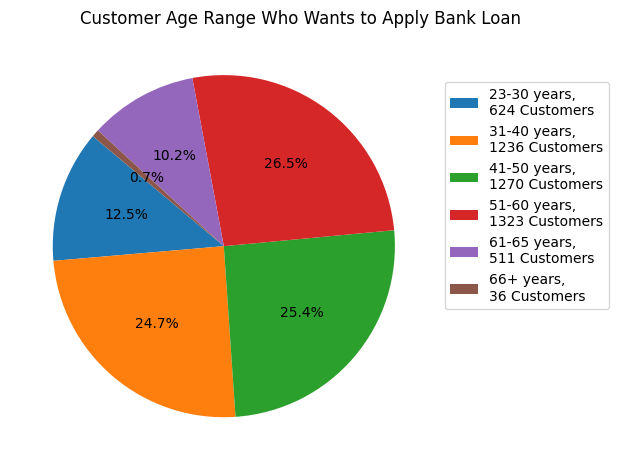

In [ ]:
fig = plt.pie( df_age['totalCustomer'], autopct='%1.1f%%', startangle=140)
labels = [f'{l} years, \n{s} Customers' for l, s in zip(df_age['Age_Gap'], df_age['totalCustomer'])]
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper left', labels=labels)
plt.title('Customer Age Range Who Wants to Apply Bank Loan', x=0.68)
plt.tight_layout()
plt.show()


How many customers reside in the specified counties?

In [ ]:
query = """
SELECT County, COUNT (County) AS totalCustomer
FROM bankLoan
WHERE County IN ('Los Angeles', 'Orange', 'San Francisco', 'Santa Clara', 'San Diego', 'Alameda', 'Sacramento', 'San Mateo', 'Contra Costa', 'Marin', 'Riverside')
GROUP BY County
"""

spark.sql(query)

County,totalCustomer
Marin,54
Orange,366
Los Angeles,1095
Sacramento,184
San Diego,568
Santa Clara,563
Contra Costa,85
San Mateo,204
Riverside,56
Alameda,500


In [ ]:
df_lived = spark.sql(query).toPandas()

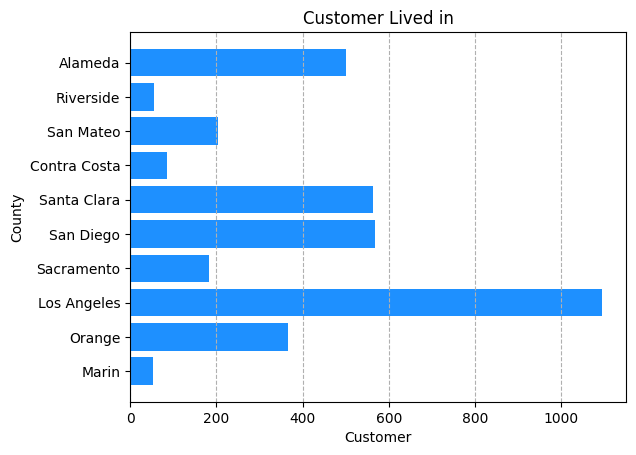

In [ ]:
fig, ax = plt.subplots()

ax.barh(df_lived['County'], df_lived['totalCustomer'], color='dodgerblue')

ax.set_xlabel("Customer")
ax.set_ylabel("County")
ax.set_title("Customer Lived in")
ax.grid(True, axis='x', linestyle="--")

plt.show()

How many customers with professional experience of more than 2 years have applied for loans and reside in the county as per the following requirement?

In [ ]:
query = """
SELECT Age_Gap, Experience_Gap, COUNT (*) AS totalCustomer
FROM bankLoan
WHERE County IN ('Los Angeles', 'Orange', 'San Francisco', 'Santa Clara', 'San Diego', 'Alameda', 'Sacramento', 'San Mateo', 'Contra Costa', 'Marin', 'Riverside')
AND Experience >=2
AND Age BETWEEN 23 AND 65
GROUP BY Age_Gap, Experience_Gap ORDER BY Age_Gap ASC
"""

spark.sql(query)

Age_Gap,Experience_Gap,totalCustomer
23-30,6-10,36
23-30,2-5,294
31-40,11-15,382
31-40,2-5,54
31-40,6-10,424
31-40,16-20,34
41-50,11-15,40
41-50,16-20,469
41-50,21+,437
51-60,21+,962


In [ ]:
df_exp = spark.sql(query).toPandas()

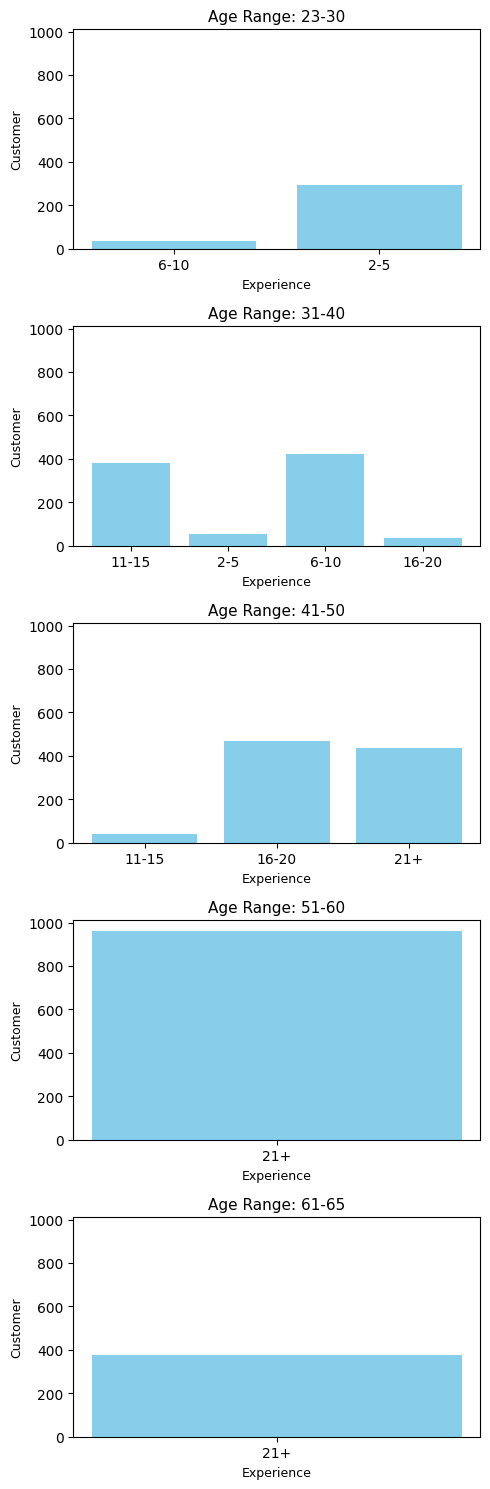

In [ ]:
# Extract unique Age_Gap values
uniqueAgeRange = df_exp['Age_Gap'].unique()

num_plots = len(uniqueAgeRange)

# Create subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(5,15),sharey=True)  # sharey=True for sharing y-axis

# Plot each Age_Gap in a separate subplot
for i, age_gap in enumerate(uniqueAgeRange):
    ax = axes[i]
    age_gap_df = df_exp[df_exp['Age_Gap'] == age_gap]
    ax.bar(age_gap_df['Experience_Gap'], age_gap_df['totalCustomer'], color='skyblue')
    ax.set_title(f'Age Range: {age_gap}', fontsize = 11)
    ax.set_xticks(range(len(age_gap_df['Experience_Gap'])))
    ax.set_ylabel('Customer', fontsize = 9)
    ax.set_xlabel('Experience', fontsize = 9)

plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()
plt.show()


What is the average income of customers in each county that meets the specified requirements?

In [ ]:
query = """
SELECT County, AVG(Income) AS AvgIncome
FROM bankLoan
WHERE County IN ('Los Angeles', 'Orange', 'San Francisco', 'Santa Clara', 'San Diego', 'Alameda', 'Sacramento', 'San Mateo', 'Contra Costa', 'Marin', 'Riverside')
AND Experience >=2
AND Age BETWEEN 23 AND 65
GROUP BY County ORDER BY County ASC
"""

spark.sql(query)

County,AvgIncome
Alameda,6142.43375732217
Contra Costa,6819.444487179486
Los Angeles,6295.27435680305
Marin,6041.666619999999
Orange,6388.323630813953
Riverside,5429.487173076925
Sacramento,5792.613630681819
San Diego,6098.137968864471
San Mateo,5894.132653061226
Santa Clara,6562.96643097015


In [ ]:
df_income = spark.sql(query).toPandas()

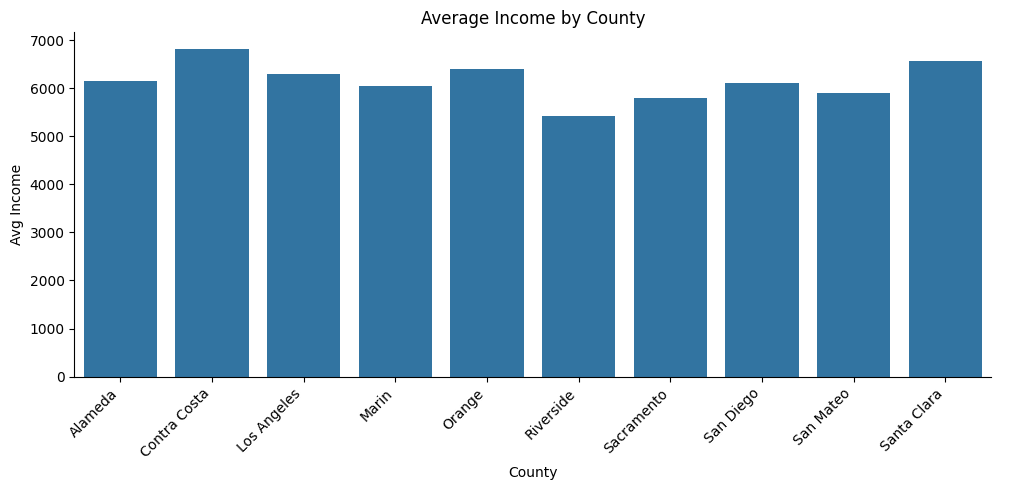

In [ ]:
sns.catplot(x='County', y='AvgIncome', kind='bar', data=df_income, aspect=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('County')
plt.ylabel('Avg Income')
plt.title('Average Income by County')
plt.tight_layout()
plt.show()

What percentage of personal loan does customer accepted before based on requirement?

In [ ]:
query = """
SELECT
  CASE
    WHEN PersonalLoan = '1' THEN 'Accepted'
    WHEN PersonalLoan = '0' THEN 'Not Accepted'
  END AS LoanStatus,
  COUNT(*) AS totalCustomer
FROM bankLoan
WHERE County IN ('Los Angeles', 'Orange', 'San Francisco', 'Santa Clara', 'San Diego', 'Alameda', 'Sacramento', 'San Mateo', 'Contra Costa', 'Marin', 'Riverside')
AND Experience >=2
AND Age BETWEEN 23 AND 65
AND INCOME >= 2500
GROUP BY PersonalLoan
"""

In [ ]:
df_accloan = spark.sql(query).toPandas()

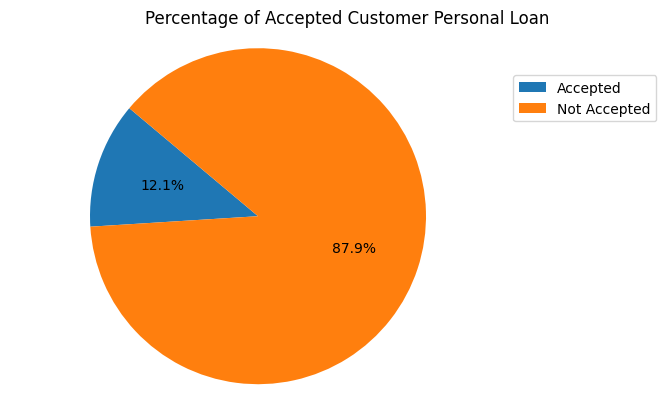

In [ ]:
fig = plt.pie(df_accloan['totalCustomer'], autopct='%1.1f%%', startangle=140)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper left', labels=df_accloan['LoanStatus'])
plt.axis('equal')
plt.title('Percentage of Accepted Customer Personal Loan',  x=0.68)
plt.show()

## Insight

- Customers aged 51-60 years are more likely to apply for bank loans compared to younger age groups.

- A total of 3,675 customers reside in counties that meet the specified requirements.

- Only about 348 customers with 2-5 years of professional experience are interested in applying for a bank loan.

- The average income in each county that meets the specified requirements is over $5,000 per month.

- Approximately 12.1% of customers have successfully applied for a bank loan in the past.

## Classification Model

Use Correlation to get feature selection

In [ ]:
corr_df = spark.sql("SELECT Age, Experience, Income, Family, CCAvg, Education, Mortgage, PersonalLoan, SecuritiesAccount, CDAccount, Online, CreditCard FROM bankLoan").toPandas()

In [ ]:
corr_df.corr()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
Age,1.000000,0.994198,-0.055269,-0.046418,-0.052012,0.041334,-0.012539,-0.007726,-0.000436,0.008043,0.013702,0.007681
Experience,0.994198,1.000000,-0.046729,-0.052213,-0.049912,0.013536,-0.010840,-0.007858,-0.001111,0.010046,0.013975,0.008910
Income,-0.055269,-0.046729,1.000000,-0.157501,0.645984,-0.187524,0.206806,0.502462,-0.002616,0.169738,0.014206,-0.002385
Family,-0.046418,-0.052213,-0.157501,1.000000,-0.109275,0.064929,-0.020445,0.061367,0.019994,0.014110,0.010354,0.011588
CCAvg,-0.052012,-0.049912,0.645984,-0.109275,1.000000,-0.136124,0.109905,0.366889,0.015086,0.136534,-0.003611,-0.006689
Education,0.041334,0.013536,-0.187524,0.064929,-0.136124,1.000000,-0.033327,0.136722,-0.010812,0.013934,-0.015004,-0.011014
Mortgage,-0.012539,-0.010840,0.206806,-0.020445,0.109905,-0.033327,1.000000,0.142095,-0.005411,0.089311,-0.005995,-0.007231
PersonalLoan,-0.007726,-0.007858,0.502462,0.061367,0.366889,0.136722,0.142095,1.000000,0.021954,0.316355,0.006278,0.002802
SecuritiesAccount,-0.000436,-0.001111,-0.002616,0.019994,0.015086,-0.010812,-0.005411,0.021954,1.000000,0.317034,0.012627,-0.015028
CDAccount,0.008043,0.010046,0.169738,0.014110,0.136534,0.013934,0.089311,0.316355,0.317034,1.000000,0.175880,0.278644


Create Feature Columns. Features That I used for this classification which are :
- Income
- Family
- CCAvg
- Education
- Mortgage
- SecuritiesAccount
- CDAccount
- Online
- CreditCard

I used those because there is a postive correlation within Personal Loan.

In [ ]:
corr_df = spark.sql("SELECT Income, Family, CCAvg, Education, Mortgage, PersonalLoan, SecuritiesAccount, CDAccount, Online, CreditCard FROM bankLoan")

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ["Income", "Family", "CCAvg", "Education", "Mortgage", "SecuritiesAccount", "CDAccount", "Online", "CreditCard"]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
features_df = assembler.transform(corr_df)

In [ ]:
features_df.show(3)

+--------+------+-----+---------+--------+------------+-----------------+---------+------+----------+--------------------+
|  Income|Family|CCAvg|Education|Mortgage|PersonalLoan|SecuritiesAccount|CDAccount|Online|CreditCard|            features|
+--------+------+-----+---------+--------+------------+-----------------+---------+------+----------+--------------------+
|4083.333|     4|  1.6|        1|       0|           0|                1|        0|     0|         0|[4083.333,4.0,1.6...|
|2833.333|     3|  1.5|        1|       0|           0|                1|        0|     0|         0|[2833.333,3.0,1.5...|
| 916.667|     1|  1.0|        1|       0|           0|                0|        0|     0|         0|(9,[0,1,2,3],[916...|
+--------+------+-----+---------+--------+------------+-----------------+---------+------+----------+--------------------+
only showing top 3 rows



Split Data

In [ ]:
train, test = features_df.randomSplit([0.7,0.3], seed=10000)

In [ ]:
print(f"Training Dataset Count: {str(train.count())}")
print(f"Test Dataset Count: {str(test.count())}")

Training Dataset Count: 3512
Test Dataset Count: 1488


Train The Model

I used Random Forest Classifier for this Dataset because :
- It can handling the multi features.
- It can handling the overfit data.
- Stability because it is based on majority voting/averaging.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

#Train The Data
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'PersonalLoan', seed=1000, numTrees=25)
random_forestModel = random_forest.fit(train)

In [ ]:
#Test the Data
predictions = random_forestModel.transform(test)
predictions.select("Income", "Family", "CCAvg", "Education", "Mortgage", "SecuritiesAccount", "CDAccount", "Online", "CreditCard", 'rawPrediction', 'prediction', 'probability').show(25)

+-------+------+-----+---------+--------+-----------------+---------+------+----------+--------------------+----------+--------------------+
| Income|Family|CCAvg|Education|Mortgage|SecuritiesAccount|CDAccount|Online|CreditCard|       rawPrediction|prediction|         probability|
+-------+------+-----+---------+--------+-----------------+---------+------+----------+--------------------+----------+--------------------+
|666.667|     1|  0.3|        1|       0|                0|        0|     1|         0|[24.7684425303913...|       0.0|[0.99073770121565...|
|666.667|     1|  0.8|        2|      97|                0|        0|     1|         0|[24.6624222688762...|       0.0|[0.98649689075504...|
|666.667|     2|  0.1|        2|       0|                0|        0|     0|         0|[24.6305111130569...|       0.0|[0.98522044452227...|
|666.667|     2|  0.3|        1|       0|                0|        0|     1|         1|[24.7817814693081...|       0.0|[0.99127125877232...|
|666.667|    

Model Evaluating

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

# AUROC
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",labelCol="PersonalLoan", metricName= "areaUnderROC")
bce.evaluate(predictions)

0.9946126101447288

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="PersonalLoan", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9863030991363915
Test Error = 0.01369690086360853


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

#Confusion Matrix
preds_and_labels = predictions.select(['prediction','PersonalLoan',"Income", "Family", "CCAvg", "Education", "Mortgage", "SecuritiesAccount", "CDAccount", "Online", "CreditCard"]).withColumn('PersonalLoan', F.col('PersonalLoan').cast(FloatType()))
preds_and_labels = preds_and_labels.select(['prediction','PersonalLoan'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(f"{metrics.confusionMatrix().toArray()}")

[[1338.    3.]
 [  23.  124.]]


In [ ]:
# precision, recall, and F1 score for each label
labels = preds_and_labels.select('PersonalLoan').distinct().rdd.flatMap(lambda x: x).collect()
for label in sorted(labels):
    print(f"Class {label} metrics:")
    print(f"  Precision: {metrics.precision(label):.4f}")
    print(f"  Recall:    {metrics.recall(label):.4f}")
    print(f"  F1 Score:  {metrics.fMeasure(label, beta=1.0):.4f}")
    print(f"\n")

# overall metrics
print(f"Overall Precision: {metrics.weightedPrecision:.4f}")
print(f"Overall Recall:    {metrics.weightedRecall:.4f}")
print(f"Overall F1 Score:  {metrics.weightedFMeasure():.4f}")

Class 0.0 metrics:
  Precision: 0.9831
  Recall:    0.9978
  F1 Score:  0.9904


Class 1.0 metrics:
  Precision: 0.9764
  Recall:    0.8435
  F1 Score:  0.9051


Overall Precision: 0.9824
Overall Recall:    0.9825
Overall F1 Score:  0.9820
